In [2]:
# imports
import keras 
import cv2 # opencv
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
kermit_data_path = '../../ground_truth/kermit/'
label_file = kermit_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

In [3]:
# this section hold useful helper functions and transformers for classifying kermit

# method for image resizing and extracting vector of raw values
def extract_value_vector(image, size=(128, 128)):
    return cv2.resize(image, size).flatten()

def extract_colour_histogram(image, bins=(32, 32, 32)):
    # convert image to hsv space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # extract color histogram from image and take all 3 channels into account
    color_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # normalize resulting histogram
    cv2.normalize(color_hist, color_hist)
    
    # print resulting historgram
    # plt.hist(image.ravel(),256,[0,256])
    # cols = ('b', 'g', 'r')
    # for i, col in enumerate(cols):
    #     histr = cv2.calcHist([image],[i],None,[256],[0,256])
    #     plt.plot(histr,color = col)
    #     plt.xlim([0,256])
    # plt.show()
    
    # return histogram as feature vector
    return color_hist.flatten()
    

def load_kermit_image_dataset():
    kermit_data = pd.DataFrame([], columns=['name', 'filename', 'kermit'])

    with open(label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = kermit_data_path + name + '_' + splits[2] + '.jpg'
            kermit_data = kermit_data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'kermit': 1 if 0 in labels else 0}, ignore_index=True)
    return kermit_data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.6*len(video1_df)), int(.8*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.6*len(video2_df)), int(.8*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.6*len(video3_df)), int(.8*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


In [4]:
df_kermit = load_kermit_image_dataset()

In [6]:
## Preprocessing and splitting data for Kermit
df_kermit_cp = df_kermit.copy()

# init data structures for feature vectors, image pixel values and labels
hist_features = []
images_raw_pixels = []

print('[INFO] start preprocessing images (color histogram)')

counter = 1
# iterate over all provided images and extract features, labels and image pixels
for idx, row in df_kermit_cp.iterrows():
    img = cv2.imread(row['filename'])
    
    # extract color distribution of the image
    img_color_hist = extract_colour_histogram(img)
    
    # extract raw pixels of the image
    img_pixels = extract_value_vector(img)

    hist_features.append(img_color_hist)
    images_raw_pixels.append(img_pixels)
    
    # show process
    if counter % 200 == 0:
        print('[INFO] images preprocessed %d/%d' % (counter, len(df_kermit_cp)))
    counter += 1
    
# add feature lists as new cols to dataframe
df_pre = df_kermit_cp.assign(color_hist = hist_features)
df_kermit_features = df_pre.assign(raw_pixels = images_raw_pixels)

# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_kermit_features)

# extract specific columns used for classification
x_train_raw = train['raw_pixels'].tolist()
x_train_hist = train['color_hist'].tolist()
y_train = train['kermit'].tolist()

x_test_raw = test['raw_pixels'].tolist()
x_test_hist = test['color_hist'].tolist()
y_test = test['kermit'].tolist()

x_validation_raw = validation['raw_pixels'].tolist()
x_validation_hist = validation['color_hist'].tolist()
y_validation = validation['kermit'].tolist()


[INFO] start preprocessing images (color histogram)
[INFO] images preprocessed 200/5333
[INFO] images preprocessed 400/5333
[INFO] images preprocessed 600/5333
[INFO] images preprocessed 800/5333
[INFO] images preprocessed 1000/5333
[INFO] images preprocessed 1200/5333
[INFO] images preprocessed 1400/5333
[INFO] images preprocessed 1600/5333
[INFO] images preprocessed 1800/5333
[INFO] images preprocessed 2000/5333
[INFO] images preprocessed 2200/5333
[INFO] images preprocessed 2400/5333
[INFO] images preprocessed 2600/5333
[INFO] images preprocessed 2800/5333
[INFO] images preprocessed 3000/5333
[INFO] images preprocessed 3200/5333
[INFO] images preprocessed 3400/5333
[INFO] images preprocessed 3600/5333
[INFO] images preprocessed 3800/5333
[INFO] images preprocessed 4000/5333
[INFO] images preprocessed 4200/5333
[INFO] images preprocessed 4400/5333
[INFO] images preprocessed 4600/5333
[INFO] images preprocessed 4800/5333
[INFO] images preprocessed 5000/5333
[INFO] images preprocessed 

In [8]:
# train a KNN classifier on raw pixel data
model_raw = KNeighborsClassifier(n_neighbors=20)
model_raw.fit(x_train_raw, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

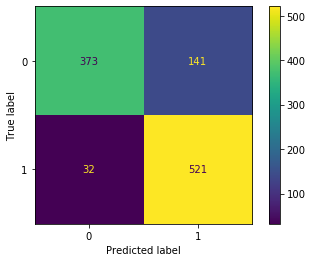

In [11]:
# print confusion matrix for KNN classifier trained on raw pixels
plot_confusion_matrix(model_raw, x_test_raw, y_test, values_format='d')
plt.show()

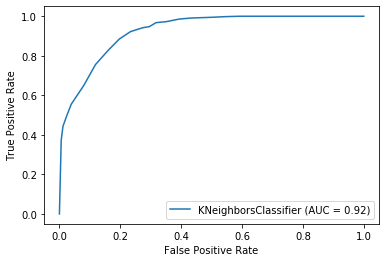

In [12]:
# print roc curve for KNN classifier trained on raw pixels
plot_roc_curve(model_raw, x_test_raw, y_test)
plt.show()

In [13]:
# train a KNN classifier on histogram features
model_hist = KNeighborsClassifier(n_neighbors=20)
model_hist.fit(x_train_hist, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

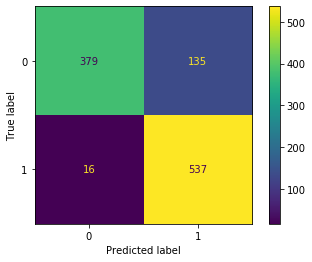

In [14]:
plot_confusion_matrix(model_hist, x_test_hist, y_test, values_format='d')
plt.show()

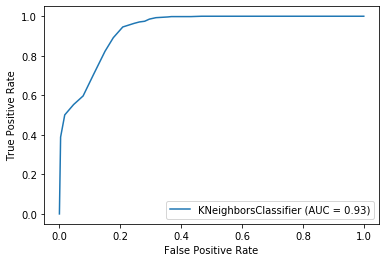

In [15]:
plot_roc_curve(model_hist, x_test_hist, y_test)
plt.show()

In [1]:
## Identifying Waldorf/Statler
